# Zonal statistics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import rasterio as rio

# get default plot dimensions to use them below
figwidth, figheight = plt.rcParams['figure.figsize']

In [2]:
# the input raster
input_filepath = '../data/clc/vaud_g100_clc00_V18_5.tif'

# let us define here how we do the zonal composition. Let the following two
# variables denote the number of pixels that each zone must have in each
# dimension (i.e., x and y, or rows and columns)

zone_num_rows = 50
zone_num_cols = 50

In [3]:
# here we will extract some important information from the raster
with rio.open(input_filepath) as src:
    landscape_arr = src.read(1)    
    num_rows, num_cols = src.shape

In [4]:
# now we will build a list of numpy masks, each representing a "zone" of our
# zonal analysis
masks = []
base_mask_arr = np.full((num_rows, num_cols), False)

for zone_row_start in range(0, num_rows, zone_num_rows):
    for zone_col_start in range(0, num_cols, zone_num_cols):
        mask_arr = np.copy(base_mask_arr)
        mask_arr[zone_row_start:zone_row_start +
                 zone_num_rows, zone_col_start:zone_col_start +
                 zone_num_cols] = True
        masks.append(mask_arr)

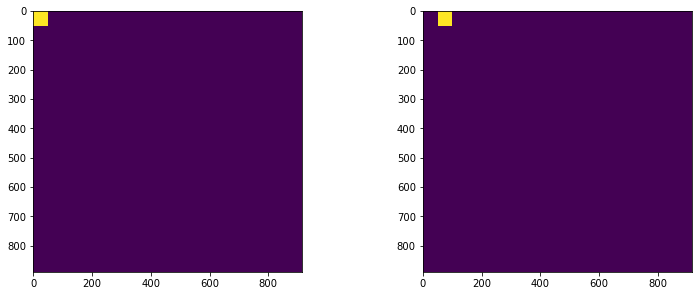

In [5]:
# let us see what these masks look like
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))

axes[0].imshow(masks[0])
axes[1].imshow(masks[1])

In [6]:
# let us now build the `ZonalAnalysis` instance.
za = pls.ZonalAnalysis(input_filepath,
                       masks_arr=masks)

In [7]:
# let us compute a data frame of landscape metrics for our zonal analysis
# in order to speed up the computations, it is better to specify only the
# classes and metrics in which we are interested, e.g.:
classes = [0, 1]
metrics = ['edge_density', 'fractal_dimension_am']

urban_ed_df = za.compute_class_metrics_df(metrics=metrics, classes=classes)

In [8]:
# in our data frame, for each class, each row corresponds to a "zone" of our
# zonal analysis
# note that there will be a bunch of `NaN` values in the data frame ...
urban_ed_df

metric                     edge_density fractal_dimension_am
class_val attribute_values                                  
0         0                         NaN                  NaN
          1                         NaN                  NaN
          2                         NaN                  NaN
          3                         NaN                  NaN
          4                         NaN                  NaN
...                                 ...                  ...
1         337                   4.08163              1.04992
          338                       NaN                  NaN
          339                       NaN                  NaN
          340                       NaN                  NaN
          341                       NaN                  NaN

[684 rows x 2 columns]

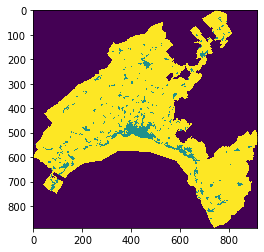

In [9]:
# ... this is because those zones correspond to `NaN` areas in our landscape
plt.imshow(landscape_arr)

In [10]:
# for the other zones, the data frame will feature the computed value for each
# of the specified metrics
urban_ed_df.dropna()

metric                     edge_density fractal_dimension_am
class_val attribute_values                                  
1         15                    7.19074               1.1239
          32                   0.580046                    1
          33                    2.50716               1.0664
          34                    8.96432              1.09781
          35                     14.557              1.06126
...                                 ...                  ...
          298                   11.7235              1.13431
          299                      5.12              1.04108
          300                      10.6              1.08737
          318                   8.05929              1.09745
          337                   4.08163              1.04992

[119 rows x 2 columns]

In [11]:
# now, in order to reconstitute our map of zones, we need to transform the list
# of zones to a matrix of zones
# to that end, we first need to get the shape of the matrix
zonal_landscape_shape = np.ceil(
    (num_rows / zone_num_rows, num_cols / zone_num_cols)).astype(int)

In [12]:
# in this example, the rows are distributed in 18 rows and 19 columns
zonal_landscape_shape

array([18, 19])

In [13]:
# now we can reconstitute, for a given land use/land cover class 
class_val = 1
metric = 'edge_density'
zonal_ed_arr = urban_ed_df.loc[class_val][metric].values.reshape(
    zonal_landscape_shape).astype(np.float32)

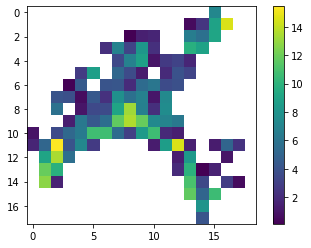

In [14]:
plt.imshow(zonal_ed_arr)
plt.colorbar()